In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.5 MB/s eta 0:00:00


In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt

# ML from sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# tf, keras and torch
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# text analysis
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

#  others
import re
from collections import Counter
import itertools
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


A few of the text variables are kept for additional text analysis:

*   title: The job title or position being advertised.
*   location: The location or place where the job is located.
*   department: The department or division within the company related to the job.
*   company_profile: Information about the company, possibly including its history, mission, and culture.
*   description: A detailed description of the job, its responsibilities, and requirements.
*   requirements: The qualifications, skills, and experience required for the job.
*   benefits: The benefits or perks associated with the job, such as health insurance, retirement plans, or other incentives.
*   employment_type: The type of employment, such as full-time, part-time, contract, or temporary.
*   required_experience: The level of experience (e.g., entry-level, mid-level, senior) expected for the job.
required_education: The minimum educational qualifications or degrees required for the job.
*   industry: The industry or sector to which the company belongs (e.g., technology, healthcare, finance).
*   function: The specific function or role of the job within the company (e.g., marketing, engineering, sales).
*   fraudulent: A binary variable indicating whether the job posting is fraudulent (1) or legitimate (0).

Missing values can cause issues when you're working with the data, such as errors during analysis or when training machine learning models. Filling in missing values with blank spaces here can help mitigate these issues. The data is then subsetted into two based on whether the job posting is potentially fraudulent or legitimate.

In [4]:
df_text = df[['title', 'location', 'department',
       'company_profile', 'description', 'requirements', 'benefits',
       'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']]
df_text = df_text.fillna(' ')

In [5]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

columns_to_process = ['title', 'location', 'department',
       'company_profile', 'description', 'requirements', 'benefits',
       'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for column in columns_to_process:
    df_text[column] = df_text[column].apply(preprocessor)

df_text_fraud = df_text.loc[df_text.fraudulent == 1]
df_text_real = df_text.loc[df_text.fraudulent == 0]

In [6]:
nltk.download('stopwords')

# Define a list of stop words
stop_words = set(stopwords.words('english'))
stop_words.add('level') # adding another word that appears frequently but doesn't add much value in analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def get_top_words(column, n=10):
    if column.dtype == 'object':
        words = [word for word in itertools.chain(*column.str.split()) if word.lower() not in stop_words]
        word_counts = Counter(words)
        top_words = dict(word_counts.most_common(n))
        return top_words
    else:
        return {}

# Get the top words for each category
top_words_fraud = {}
top_words_real = {}

for column in df_text_fraud.columns:
    top_words_fraud[column] = get_top_words(df_text_fraud[column])

for column in df_text_real.columns:
    top_words_real[column] = get_top_words(df_text_real[column])

The text data is then processed from two categories of job postings (fraudulent and legitimate) to identify the most common words in each category. This information can be useful as we will be able to understand the key terms used in each category or identifying potential indicators of fraudulent job postings.

## Word Frequency

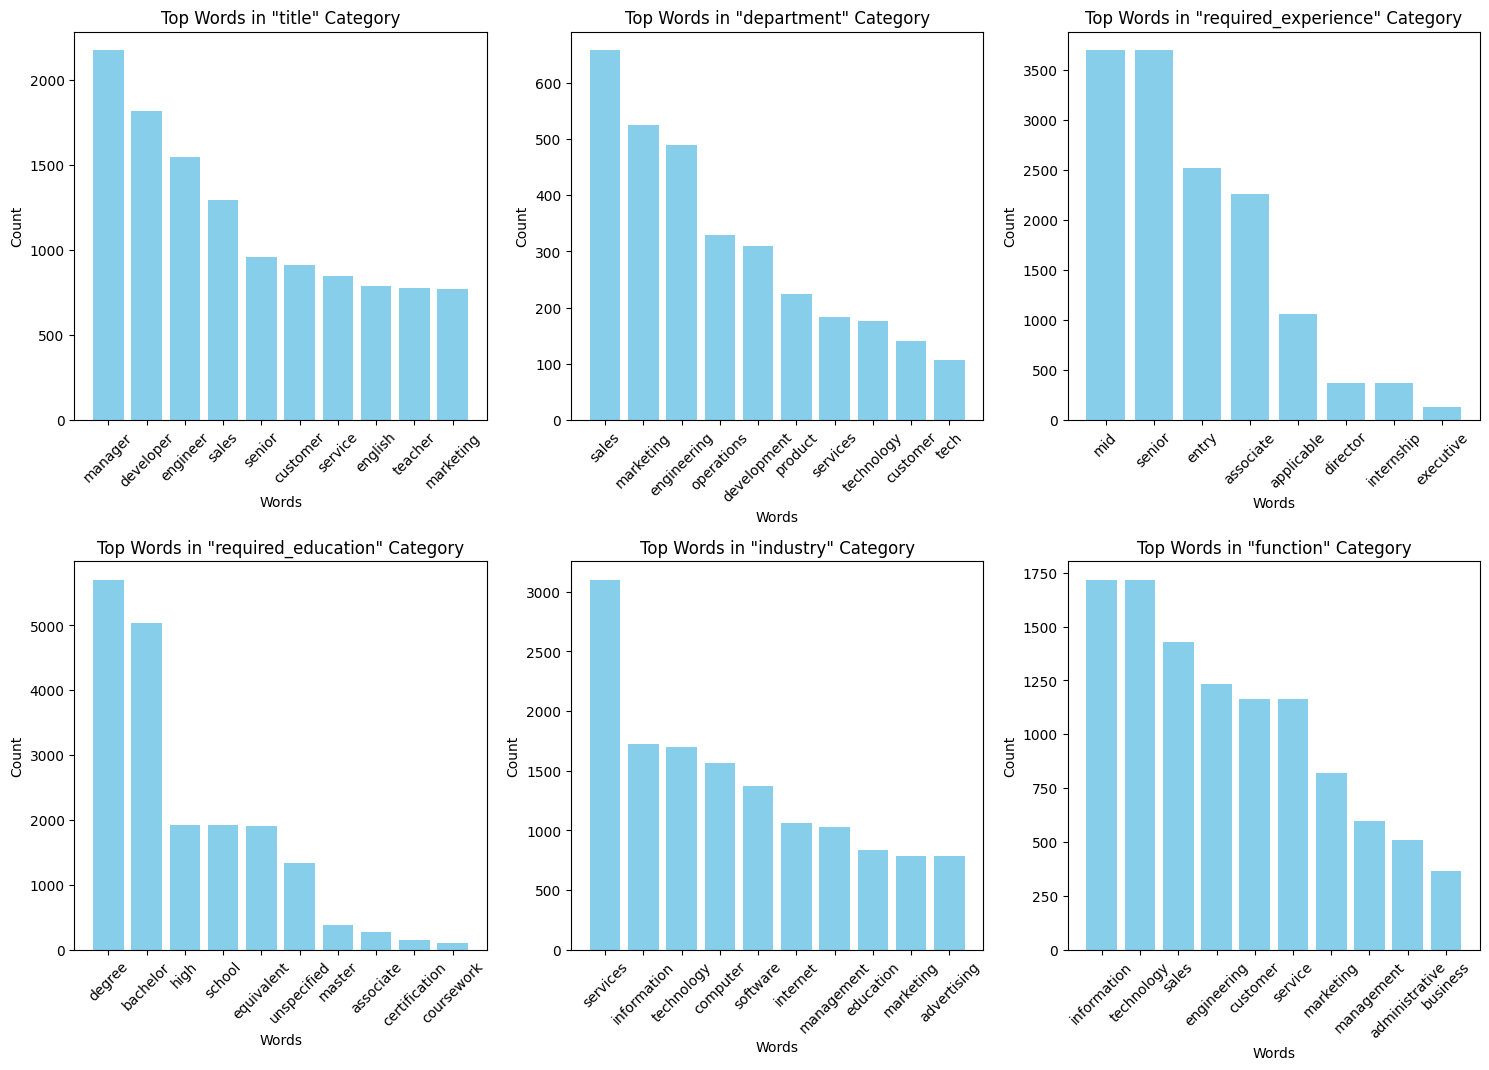

In [8]:
# Create subplots for each category (3 in a row)
top_words_real = {key: value for key, value in top_words_real.items() if key not in ['fraudulent', 'location',
                                                                                     'company_profile', 'benefits',
                                                                                    'employment_type', 'description',
                                                                                    'requirements']}
categories = list(top_words_real.keys())
num_categories = len(categories)
num_plots_per_row = 3

fig, axes = plt.subplots(
    num_categories // num_plots_per_row + 1, num_plots_per_row,
    figsize=(15, 5 * (num_categories // num_plots_per_row + 1)))

for i, (category, values) in enumerate(top_words_real.items()):
    words = list(values.keys())
    counts = list(values.values())

    ax = axes[i // num_plots_per_row, i % num_plots_per_row]
    ax.bar(words, counts, color='skyblue')
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')
    ax.set_title(f'Top Words in "{category}" Category')

    # Rotate the x-axis labels to 45 degrees
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
for i in range(len(categories), len(axes.ravel())):
    fig.delaxes(axes.ravel()[i])

plt.tight_layout()
plt.show()

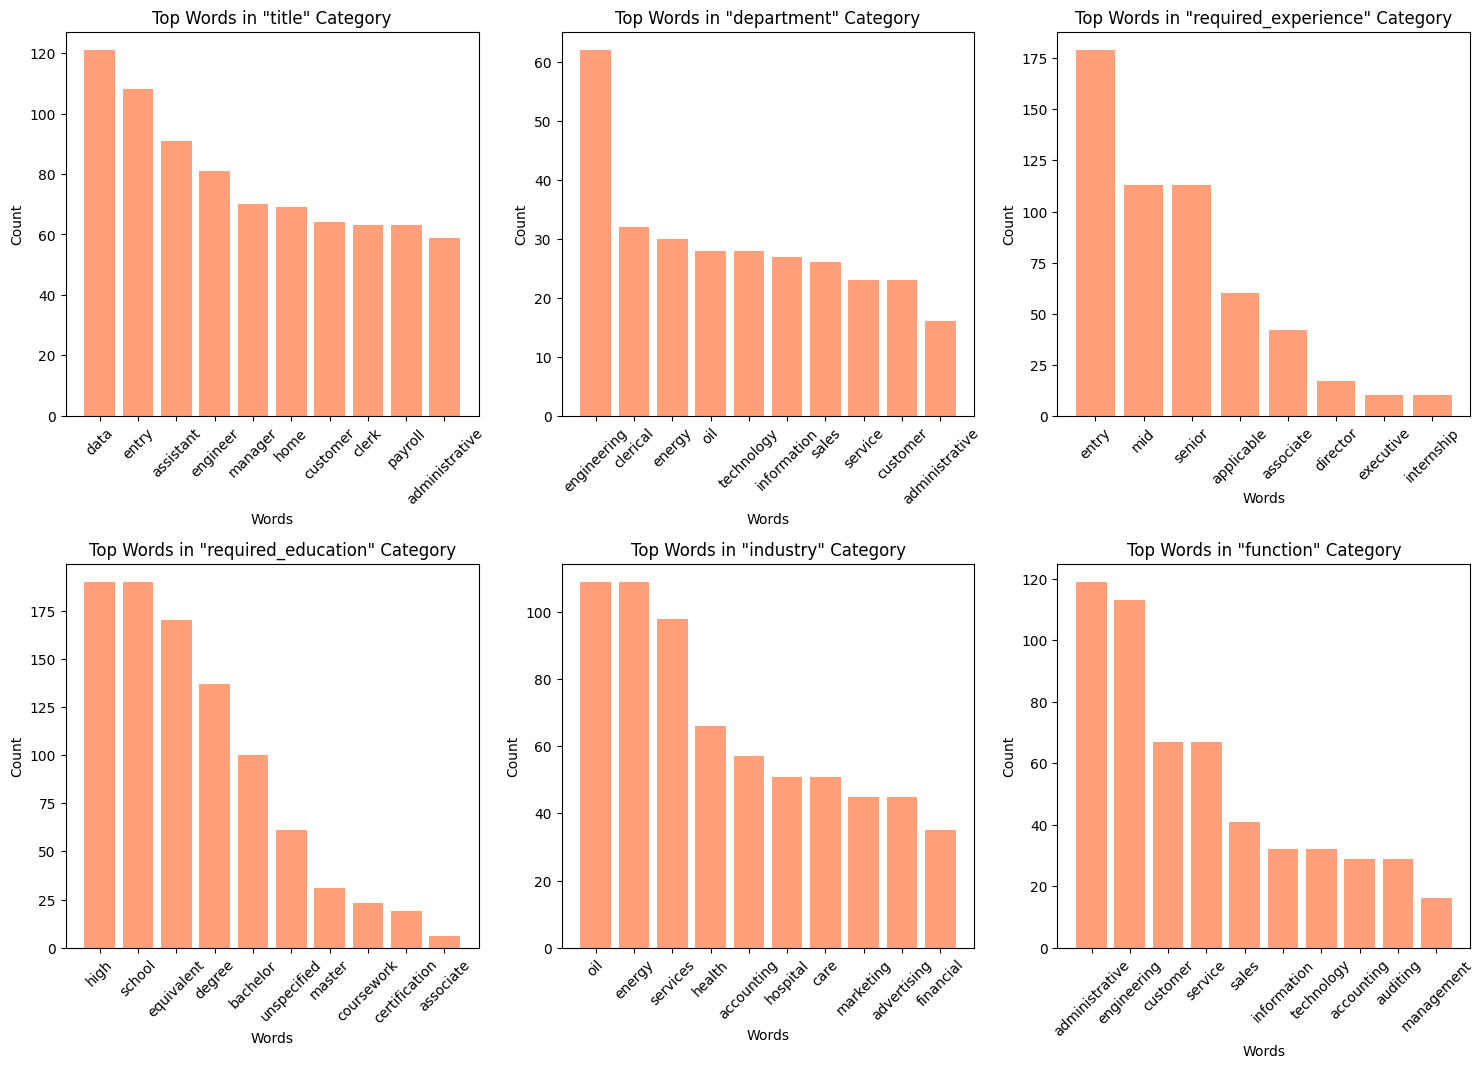

In [9]:
# Create subplots for each category (3 in a row)
top_words_fraud = {key: value for key, value in top_words_fraud.items() if key not in ['fraudulent', 'location',
                                                                                     'company_profile', 'benefits',
                                                                                    'employment_type', 'description',
                                                                                    'requirements']}
categories = list(top_words_fraud.keys())
num_categories = len(categories)
num_plots_per_row = 3

fig, axes = plt.subplots(
    num_categories // num_plots_per_row + 1, num_plots_per_row,
    figsize=(15, 5 * (num_categories // num_plots_per_row + 1)))

for i, (category, values) in enumerate(top_words_fraud.items()):
    words = list(values.keys())
    counts = list(values.values())

    ax = axes[i // num_plots_per_row, i % num_plots_per_row]
    ax.bar(words, counts, color='#FFA07A')
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')
    ax.set_title(f'Top Words in "{category}" Category')

    # Rotate the x-axis labels to 45 degrees
    ax.tick_params(axis='x', rotation=45)

# Remove any empty subplots
for i in range(len(categories), len(axes.ravel())):
    fig.delaxes(axes.ravel()[i])

plt.tight_layout()
plt.show()

Potentially fraudulent job postings often contain terms associated with low-skill or entry-level positions, while legitimate job postings have a more diverse range of experience requirements.

The industries and functions associated with potentially fraudulent job postings are more varied, such as 'oil,' 'energy,' 'services,' 'health,' and 'accounting', whereas legitimate job postings are concentrated in specific industries and functions such as 'services,' 'information,' 'technology,' and 'computer'.

Specific words in job titles, departments, and educational requirements can help distinguish potentially fraudulent postings from legitimate ones. For instance, fraudulent job postings have most of the required eduation as in high school, while legitimate postings a degreed education.

## Embeddings

In [10]:
df_text['text_analysis'] = df_text['company_profile'] + ' ' + \
                           df_text['benefits'] + ' ' + \
                           df_text['description'] + ' ' + \
                           df_text['requirements']
df_text_analysis = df_text[[ 'text_analysis','fraudulent', ]]

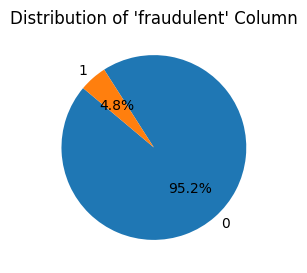

In [11]:
# Count the values in the "fraudulent" column
value_counts = df_text_analysis['fraudulent'].value_counts(dropna=False)

plt.figure(figsize=(3, 3))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of 'fraudulent' Column")
plt.show()


## Dealing with data imbalance with Oversampling + RF

In [12]:
# Split the data into features and labels
X = df_text_analysis['text_analysis']
y = df_text_analysis['fraudulent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text data preprocessing - you can customize this as needed
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Resample the training data using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train a classification model (Random Forest in this example)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.99      0.65      0.78       181

    accuracy                           0.98      3576
   macro avg       0.99      0.82      0.89      3576
weighted avg       0.98      0.98      0.98      3576



The text data is preprocessed using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. We created a TF-IDF vectorizer with a maximum of 5000 features and it converts text data into numerical vectors, where each word's importance is weighted based on its frequency and rarity.

To address the class imbalance problem, we applied Synthetic Minority Over-sampling Technique (SMOTE), which generates synthetic examples of the minority class (fraudulent job postings) to balance the class distribution.

Random Forest algorithm is chosen for its ability to handle both numerical and text data effectively.

The results show a high level of accuracy and effectiveness in identifying legitimate job postings, but there is some room for improvement in detecting potentially fraudulent job postings, particularly in terms of recall. A low recall score means it's not as effective at identifying all potentially fraudulent postings. However, it has high precision, which means that when it predicts a job posting as potentially fraudulent, it's usually correct.

## Dealing with data imbalance with Undersampling + NN

An alternative would be dealing with data imbalance with undersampling the majority class.

In [13]:
import pandas as pd
from sklearn.utils import resample

# Separate the data into two DataFrames based on the class
df_majority = df_text_analysis[df_text_analysis['fraudulent'] == 0]
df_minority = df_text_analysis[df_text_analysis['fraudulent'] == 1]

# Undersample the majority class to match the count of the minority class
n_samples = len(df_minority)
df_majority_undersampled = resample(df_majority, n_samples=n_samples, replace=False, random_state=42)

# Create a new DataFrame with balanced classes
df_text_analysis_undersample = pd.concat([df_majority_undersampled, df_minority])

# Verify the class distribution
df_text_analysis_undersample['fraudulent'].value_counts()

0    866
1    866
Name: fraudulent, dtype: int64

In [14]:
# define target
target = df_text_analysis_undersample.copy().pop('fraudulent') # .pop removes sentiment col from df
# target and review combined tensors
data_tf = tf.data.Dataset.from_tensor_slices(
    (df_text_analysis_undersample[['text_analysis']].values, target.values)
)


In [15]:
# set random seed
tf.random.set_seed(1)

# define splits for training, validation, test
splits=[0.6, 0.2, 0.2]

# shuffle data
data_tf = data_tf.shuffle(
    df_text_analysis_undersample.shape[0], reshuffle_each_iteration=False)

data_tf_test = data_tf.take(int(df_text_analysis_undersample.shape[0]*splits[2]))
data_tf_train_valid = data_tf.skip(int(df_text_analysis_undersample.shape[0]*splits[2]))
data_tf_train = data_tf_train_valid.take(int(df_text_analysis_undersample.shape[0]*splits[0]))
data_tf_valid = data_tf_train_valid.skip(int(df_text_analysis_undersample.shape[0]*splits[0]))

In [16]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)

print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 18925


In [17]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

In [18]:
# define function for token encoder
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

#  wrap the encode function to a TF Operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label],
                          Tout=(tf.int64, tf.int64))

In [19]:
# the encode_map_fn is defined at the top of the notebook
data_tf_train = data_tf_train.map(encode_map_fn)
data_tf_valid = data_tf_valid.map(encode_map_fn)
data_tf_test = data_tf_test.map(encode_map_fn)

In [20]:
# define batch size
batch_size = 32

# batcing of training, validation and test partitions
train_data = data_tf_train.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

valid_data = data_tf_valid.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

test_data = data_tf_test.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

Average sequence length in training mini-batches: 895


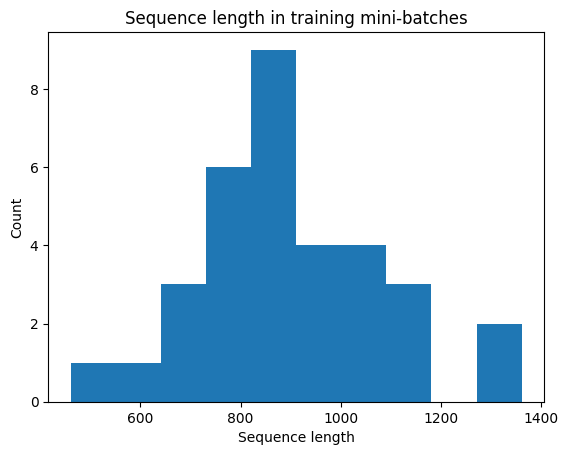

In [21]:
# histogram of sequence length in training mini-batches
seq_len_train = []
for batch in train_data:
    seq_len_train.append(batch[0].shape[1])

print('Average sequence length in training mini-batches:',
      int(sum(seq_len_train)/len(seq_len_train))
)

# histogram
plt.hist(seq_len_train)
plt.title('Sequence length in training mini-batches')
plt.ylabel('Count')
plt.xlabel('Sequence length');

Afetr undersampling the majority class and preprocessing the text data, we are prepared to have it ready for training the classification model. The data is then split into training, validation, and test sets.

In [22]:
# Embed our training vocabulary into 10 dimensions.
vocab_size_train = len(token_counts) + 2
embedding_dim = 20

embedding_layer = tf.keras.layers.Embedding(
    vocab_size_train,
    embedding_dim,
)

In [23]:
vocab_size_train = len(token_counts) + 2
embedding_dim = 20

model = tf.keras.Sequential()
# add embedding layer (this is our imput layer)
# embeddings will be learned during training
# the weights for the embeddings are randomly initialized (just like any other layer!)
model.add(Embedding(
    vocab_size_train,
    embedding_dim,
    #input_length=100, #limits length of sentence to 100 tokens
    name="embedding")
    ),


# average over the emedding dimension, so each review is represented by a 1 vector of size embedding_dimension
model.add(GlobalAveragePooling1D()),

# add a Dense layer of dimension 16
model.add(Dense(16, activation='relu')),

# add Dropout for regularization
model.add(Dropout(0.5))

# add last layer (binary classification task)
model.add(Dense(1, activation='sigmoid'))


# save embeddings before training
embeddings_untrained = model.get_layer('embedding').get_weights()[0]

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          378540    
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 378893 (1.45 MB)
Trainable params: 378893 (1.45 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [25]:
# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15)

Epoch 1/15
33/33 [==============================] - 13s 199ms/step - loss: 0.6906 - accuracy: 0.5448 - val_loss: 0.6883 - val_accuracy: 0.5418
Epoch 2/15
33/33 [==============================] - 2s 59ms/step - loss: 0.6856 - accuracy: 0.6015 - val_loss: 0.6809 - val_accuracy: 0.6427
Epoch 3/15
33/33 [==============================] - 2s 57ms/step - loss: 0.6779 - accuracy: 0.6410 - val_loss: 0.6707 - val_accuracy: 0.6571
Epoch 4/15
33/33 [==============================] - 1s 45ms/step - loss: 0.6648 - accuracy: 0.6670 - val_loss: 0.6562 - val_accuracy: 0.6888
Epoch 5/15
33/33 [==============================] - 1s 45ms/step - loss: 0.6446 - accuracy: 0.6891 - val_loss: 0.6375 - val_accuracy: 0.7147
Epoch 6/15
33/33 [==============================] - 1s 44ms/step - loss: 0.6271 - accuracy: 0.7074 - val_loss: 0.6168 - val_accuracy: 0.7349
Epoch 7/15
33/33 [==============================] - 1s 45ms/step - loss: 0.5950 - accuracy: 0.7507 - val_loss: 0.5916 - val_accuracy: 0.7666
Epoch 8/15


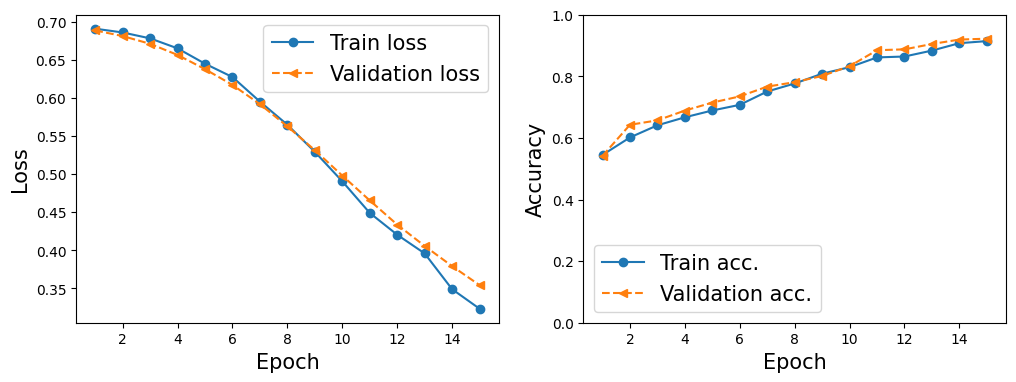

In [26]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [27]:
print('After training this model for 10 epochs, evaluation on the validation data shows an accuracy of:')
print(np.round(hist['val_accuracy'][-1]*100,2), '%')

After training this model for 10 epochs, evaluation on the validation data shows an accuracy of:
92.22 %


In [28]:
test_results = model.evaluate(test_data)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

11/11 [==============================] - 0s 33ms/step - loss: 0.3744 - accuracy: 0.8786

Test Acc. 87.86%


The sequential model is trained over 15 epochs, with each epoch comprising 33 steps. It shows significant improvement in performance over the epochs. The training accuracy reaches 91.43%, and the validation accuracy reaches 92.22% by the end of training.

Overall, the model appears to be well-designed and trained effectively for the given text classification task. Its strong performance on both training and validation data indicates its ability to make accurate predictions. However, the model's performance on unseen test data would provide a more comprehensive assessment of its generalization ability.

## Applying transformers

A transformer is a type of neural network architecture used for various natural language processing tasks. It's known for its ability to handle sequential data efficiently, including text, audio, and more.They rely on a mechanism called self-attention, which allows them to weigh the importance of different elements in a sequence when making predictions.

BERT is a specific pre-trained transformer model that has been fine-tuned for various NLP tasks. It understands the context of words in a sentence by considering the words that come before and after each word. This bidirectional understanding of language allows it to capture complex relationships between words.

In this case, a pre-trained BERT model is used for fine-tuning to classify job postings (on undersampling dataset) as either fraudulent or legitimate.

In [29]:
# Encode the labels
label_encoder = LabelEncoder()
df_text_analysis_undersample['fraudulent'] = label_encoder.fit_transform(df_text_analysis_undersample['fraudulent'])

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_text_analysis_undersample['text_analysis'],
    df_text_analysis_undersample['fraudulent'],
    test_size=0.2,
    random_state=42
)
train_labels = np.array(train_labels, dtype=np.long)
test_labels = np.array(test_labels, dtype=np.long)

In [30]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Tokenize the text and create DataLoader
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)


In [32]:
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels, dtype=torch.long)
)

In [33]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Set up training parameters
epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [34]:
# Fine-tune the BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [35]:
device

device(type='cuda')

In [36]:
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [37]:
# Make predictions
predictions = []
for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].cpu().numpy()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.extend(logits.argmax(dim=1).cpu().numpy())

# Decode labels back to original format
test_labels = label_encoder.inverse_transform(test_labels)
predictions = label_encoder.inverse_transform(predictions)

# Evaluate the model
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       182
           1       0.94      0.98      0.96       165

    accuracy                           0.96       347
   macro avg       0.96      0.96      0.96       347
weighted avg       0.96      0.96      0.96       347



The model achieves an accuracy of 96% on the testing data, indicating that it accurately classifies job postings as fraudulent or legitimate. The precision and recall for both classes are high, which means the model is effective in making accurate predictions with a good balance between false positives and false negatives.